## 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 기본 import

In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 746.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.0 MB/s eta 0:00:00


In [4]:
import os, re, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

# 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), f"데이터 파일 MISSING: {DATA_PATH}"

## 데이터 파싱
- 우리가 학습해야 하는 건 활동 라벨(jogging, upstairs, …)이고, timestamp는 시계열의 순서와 일정한 샘플 간격(≈20Hz) 을 보존·재구성하는 데 쓰는 도구임을 생각
### 데이터 구조
- 입력 X: 센서 값 시퀀스 [(x,y,z)_t]
- 라벨 y: 윈도우(10s=200스텝) 단위의 활동 클래스
- timestamp의 역할:
  - 사용자별로 정렬(user, timestamp)
  - 간격 확인(≈50ms) 후 균일 리샘플(20Hz)
  - 슬라이딩 윈도우(길이 200, 스트라이드 100 등) 생성
- 즉 이렇게 만든 고정길이 시퀀스를 LSTM/CNN-LSTM에 입력해 학습시키는것이 맞는것같다

In [13]:
import re, pandas as pd

def load_wisdm_regex_strict(path: str) -> pd.DataFrame:
    pat = re.compile(
        r"^\s*(\d+)\s*,\s*([A-Za-z_]+)\s*,\s*(\d+)\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*;?\s*$"
    )
    rows = []
    with open(path, 'r') as f:
        for line in f:
            m = pat.match(line)
            if m:
                u, a, t, x, y, z = m.groups()
                rows.append((int(u), a.strip(), int(t), float(x), float(y), float(z)))
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    # 결측/비정상 값 제거 (남겨두면 나중에 0으로 치울 유혹이 생김)
    df = df.dropna(subset=['user','activity','timestamp','x','y','z']).copy()
    df = df.sort_values(['user','timestamp'], kind='mergesort').reset_index(drop=True)
    return df

df = load_wisdm_regex_strict(DATA_PATH)
print(df[['timestamp','x','y','z']].describe())

# 파싱 잘 되었는지 확인
print(df.head())
df[['timestamp','x','y','z']].head(10)

# 샘플링 주기 확인
g = df[df.user==1].sort_values('timestamp')
dt = np.diff(g['timestamp'].to_numpy())
print(np.median(dt))   # ≈ 50_000_000 (ns)면 됨 → 0.05s = 20Hz


          timestamp             x             y             z
count  1.086465e+06  1.086465e+06  1.086465e+06  1.086465e+06
mean   3.250279e+13  6.641130e-01  7.246045e+00  3.976974e-01
std    4.893650e+13  6.876277e+00  6.739789e+00  4.761111e+00
min    0.000000e+00 -1.961000e+01 -1.961000e+01 -1.980000e+01
25%    1.999712e+12 -2.910000e+00  3.170000e+00 -2.220117e+00
50%    9.396203e+12  2.700000e-01  7.930000e+00  0.000000e+00
75%    3.509473e+13  4.440000e+00  1.156000e+01  2.720000e+00
max    2.093974e+14  1.995000e+01  2.004000e+01  1.961000e+01
   user activity      timestamp     x      y     z
0     1  Walking  4991922345000  0.69  10.80 -2.03
1     1  Walking  4991972333000  6.85   7.44 -0.50
2     1  Walking  4992022351000  0.93   5.63 -0.50
3     1  Walking  4992072339000 -2.11   5.01 -0.69
4     1  Walking  4992122358000 -4.59   4.29 -1.95
49988000.0


# EDA

In [14]:
# 결측/이상치
print(df.isna().mean())
print((df['timestamp']<=0).sum(), "zeros/neg timestamps")
print((df[['x','y','z']].abs()>19.6).any(axis=1).mean(), "sat%")

# 샘플링 간격(예: user=1)
g = df[df.user==1].sort_values('timestamp')
dt = g['timestamp'].diff().dropna()
dt_ms = dt/1e6
print("median Δt(ms):", dt_ms.median())

user         0.0
activity     0.0
timestamp    0.0
x            0.0
y            0.0
z            0.0
dtype: float64
12842 zeros/neg timestamps
0.010437519846474575 sat%
median Δt(ms): 49.988


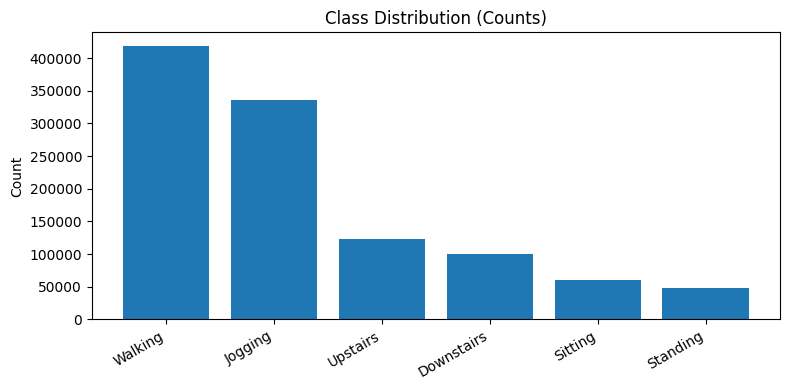

In [15]:
# 전체 클래스 분포: 개수
cls_counts = df['activity'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(cls_counts.index.astype(str), cls_counts.values)
plt.title('Class Distribution (Counts)')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

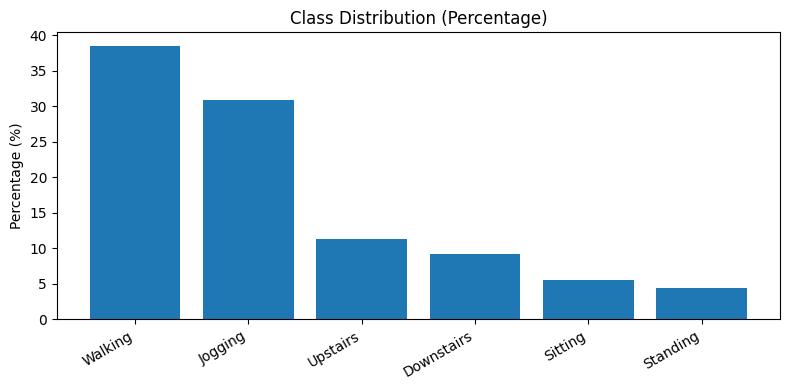

In [16]:
# 전체 클래스 분포: 비율
cls_ratio = (cls_counts / cls_counts.sum()) * 100

plt.figure(figsize=(8,4))
plt.bar(cls_ratio.index.astype(str), cls_ratio.values)
plt.title('Class Distribution (Percentage)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

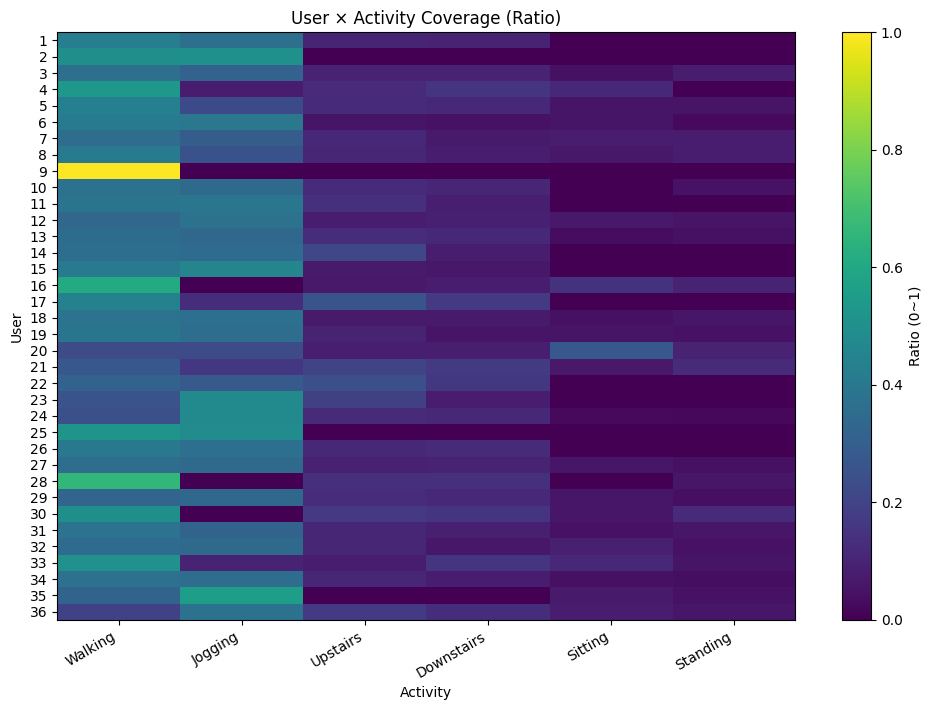

In [17]:
# 사용자 × 활동 커버리지: 히트맵
# 사용자별 각 활동 비율(= 사용자 총 샘플 대비 활동 샘플 비율)
pv_count = df.pivot_table(index='user', columns='activity', values='x', aggfunc='count').fillna(0)
pv_ratio = pv_count.div(pv_count.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

# 활동 열 순서(전체 빈도가 높은 순으로 정렬)
act_order = cls_counts.index.tolist()
pv_ratio = pv_ratio.reindex(columns=act_order)

plt.figure(figsize=(10, max(4, pv_ratio.shape[0]*0.20)))  # 유저가 많으면 세로 늘려도 됨
im = plt.imshow(pv_ratio.values, aspect='auto', interpolation='nearest')
plt.title('User × Activity Coverage (Ratio)')
plt.xlabel('Activity')
plt.ylabel('User')

# x축: 활동 라벨
plt.xticks(ticks=np.arange(len(pv_ratio.columns)),
           labels=pv_ratio.columns.astype(str),
           rotation=30, ha='right')
# y축: 유저 라벨임)
users = pv_ratio.index.to_list()
step = max(1, len(users)//30)  # 최대 30개까지 표시
plt.yticks(ticks=np.arange(0, len(users), step), labels=[users[i] for i in range(0, len(users), step)])

# 색상 바
cbar = plt.colorbar(im)
cbar.set_label('Ratio (0~1)', rotation=90)

plt.tight_layout()
plt.show()

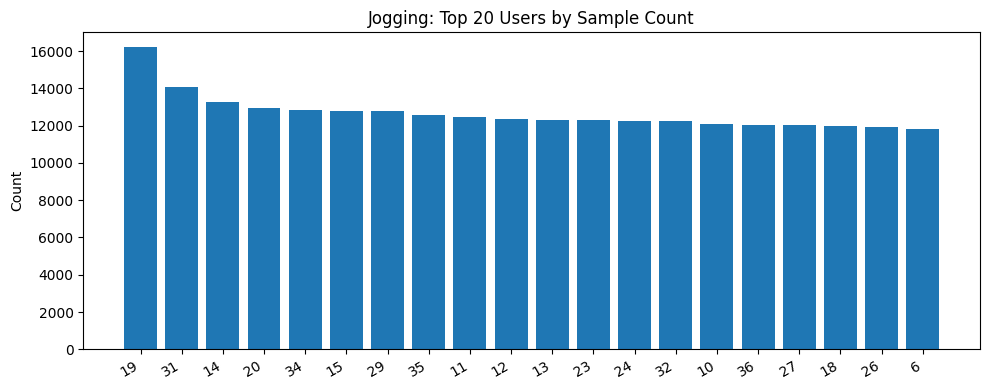

In [18]:

# 활동별 샘플 수 상위/하위 사용자 Top-N
# 특정 활동의 사용자 편향을 보기 위함
target_act = 'Jogging'
by_user = df[df['activity']==target_act].groupby('user').size().sort_values(ascending=False)

N = 20
plt.figure(figsize=(10,4))
plt.bar(by_user.index.astype(str)[:N], by_user.values[:N])
plt.title(f'{target_act}: Top {N} Users by Sample Count')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

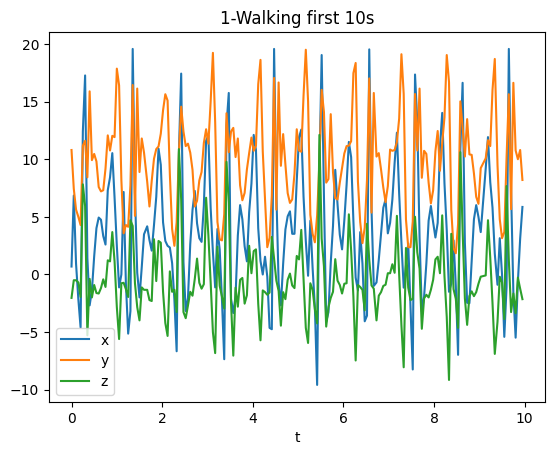

In [19]:
# 예: user 1의 walking
u, act = 1, 'Walking'
g = df[(df.user==u)&(df.activity==act)].sort_values('timestamp').copy()
g['t'] = (g['timestamp'] - g['timestamp'].iloc[0]) / 1e9
ax = g.iloc[:200].plot(x='t', y=['x','y','z'], title=f'{u}-{act} first 10s')

# 전처리

## 1. 라벨 인코딩 (Label Encoding)
- 문자 라벨(‘Walking’, ‘Jogging’, …)을 정수 ID(0,1,2,…)로 변환.
- 분류 모델(softmax)은 보통 정수 라벨을 요구하고, 손실함수(sparse_categorical_crossentropy)와 직결

In [20]:
# 라벨 인코딩
activities = sorted(df['activity'].unique().tolist())
lab2id = {a:i for i,a in enumerate(activities)}
id2lab = {i:a for a,i in lab2id.items()}
df['label'] = df['activity'].map(lab2id).astype('int32')

# 유저/타임스탬프 정렬(안 되어 있다면)
df = df.sort_values(['user','timestamp'], kind='mergesort').reset_index(drop=True)

# 동일 유저 내에서 activity가 바뀌는 지점을 run으로 나눔(연속 세그먼트)
# run_id는 유저별로 activity가 바뀔 때마다 +1
activity_changed = (df['activity'] != df.groupby('user')['activity'].shift()).astype('int32')
df['run_id'] = activity_changed.groupby(df['user']).cumsum().astype('int32')

print("labels:", lab2id)
print(df.head())

labels: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
   user activity      timestamp     x      y     z  label  run_id
0     1  Walking  4991922345000  0.69  10.80 -2.03      5       1
1     1  Walking  4991972333000  6.85   7.44 -0.50      5       1
2     1  Walking  4992022351000  0.93   5.63 -0.50      5       1
3     1  Walking  4992072339000 -2.11   5.01 -0.69      5       1
4     1  Walking  4992122358000 -4.59   4.29 -1.95      5       1


## 2. 슬라이딩 윈도우 (경계 보존)
- 균일 시계열(예: 20 Hz)에서 길이 T=200(10초)짜리 조각을 일정 간격(stride=100=5초)으로 잘라 (200, 채널) 시퀀스 샘플을 생성
- 유저/액티비티 경계를 넘지 않도록 (user, run_id) 세그먼트 내에서만 윈도우를 생성함
- 사용자별로 타임스탬프 오름차순 정렬 후, activity가 바뀌는 지점마다 run_id를 증가시키고, (user, run_id) 그룹별로만 윈도우를 자름
- 각 run에서 만들어진 (윈도우, 라벨, 유저)를 리스트에 쌓고 마지막에 한 번에 concatenate

In [22]:
# 슬라이딩 윈도우(경계 보존: user/run_id 단위로 자르기)
SEQ_LEN = 200   # 10s @ 20Hz
STRIDE  = 100   # 5s overlap

def make_windows_from_segment(g: pd.DataFrame, seq_len=SEQ_LEN, stride=STRIDE):
    arr = g[['x','y','z']].to_numpy(dtype=np.float32)   # (N, 3)
    n = len(arr)
    if n < seq_len:
        return None

    # 시작 인덱스들
    starts = range(0, n - seq_len + 1, stride)
    Xs = [arr[s:s+seq_len] for s in starts]
    # 세그먼트 내 activity가 동일하므로 첫 라벨 사용
    lab = int(g['label'].iloc[0])
    ys  = [lab] * len(Xs)
    us  = [int(g['user'].iloc[0])] * len(Xs)
    return np.stack(Xs), np.asarray(ys, dtype=np.int64), np.asarray(us, dtype=np.int64)

# 전체 데이터에 대해 윈도우 생성 (user, run_id 단위)
X_list, y_list, u_list = [], [], []
for (uid, run), g in df.groupby(['user','run_id'], sort=False):
    out = make_windows_from_segment(g)
    if out is None:
        continue
    Xs, ys, us = out
    X_list.append(Xs); y_list.append(ys); u_list.append(us)

X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,SEQ_LEN,3), np.float32)
y_all = np.concatenate(y_list, axis=0) if y_list else np.empty((0,), np.int64)
u_all = np.concatenate(u_list, axis=0) if u_list else np.empty((0,), np.int64)

print("Windows:", X_all.shape, y_all.shape, " unique users:", np.unique(u_all).size)


Windows: (10238, 200, 3) (10238,)  unique users: 36


## 3 유저 기준 분할
- 학습/검증/테스트를 사람 단위로 나눔
- 같은 사람의 데이터가 Train과 Test에 동시에 들어가면, 모델이 개인 특성을 외워 과대추정
  - 이 코드는 같은 사람의 윈도우가 서로 다른 세트에 섞이지 않아 일반화 평가 가능
- np.random.permutation(unique_users)로 사용자 ID를 섞고, 집합을 Train/Val/Test로 나눈 다음, 윈도우 단위의 샘플을 사용자 집합으로 필터링


In [24]:
# 유저 기준 분할(subject-wise split)
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

users = np.unique(u_all)
users = rng.permutation(users)

n = len(users)
n_tr = int(0.7 * n)
n_va = int(0.1 * n)

train_users = set(users[:n_tr])
val_users   = set(users[n_tr:n_tr+n_va])
test_users  = set(users[n_tr+n_va:])

def select_by_users(X, y, u, keep: set):
    idx = np.where(np.isin(u, list(keep)))[0]
    return X[idx], y[idx], u[idx]

X_tr, y_tr, u_tr = select_by_users(X_all, y_all, u_all, train_users)
X_va, y_va, u_va = select_by_users(X_all, y_all, u_all, val_users)
X_te, y_te, u_te = select_by_users(X_all, y_all, u_all, test_users)

print("Train:", X_tr.shape, "Val:", X_va.shape, "Test:", X_te.shape)
print("Train users:", len(np.unique(u_tr)), "Val users:", len(np.unique(u_va)), "Test users:", len(np.unique(u_te)))

Train: (7210, 200, 3) Val: (993, 200, 3) Test: (2035, 200, 3)
Train users: 25 Val users: 3 Test users: 8


# A - 파생채널 추가
## add_derived_channels
- 가속도의 벡터 크기
- Walking vs Upstairs/Downstairs 처럼 진폭 차이가 큰 클래스 분리에 도움

## hpf_windows
- 한 스텝에서 다음 스텝으로의 변화량
  - 연속한 두 시점의 값 차이(Δ)
  - 시계열에서 한 스텝에서 다음 스텝으로 얼마나 바뀌었는지를 확인해 고주파(빠른 변화)에 민감하도록 설정,
  - 그러나 노이즈도 키울 수 있다.
- Stairs ↔ Walking 혼동 감소, Jogging의 높은 주기성 포착


In [25]:
import numpy as np

def add_derived_channels(X):  # X: (N,T,3) -> (N,T,7)  [x,y,z,r,dx,dy,dz]
    x, y, z = X[...,0], X[...,1], X[...,2]
    r = np.sqrt(x*x + y*y + z*z)
    def td(a):
        return np.diff(a, axis=1, prepend=a[:, :1])
    dx, dy, dz = td(x), td(y), td(z)
    X_new = np.stack([x, y, z, r, dx, dy, dz], axis=-1).astype(np.float32)
    return X_new

#
def hpf_windows(X, fs=20.0, fc=0.3, order=3):
    try:
        from scipy.signal import butter, filtfilt
    except Exception as e:
        print("scipy.signal 없음 → HPF 생략:", e)
        return X
    b, a = butter(order, fc/(fs/2), btype='high', output='ba')
    Xf = np.empty_like(X)
    for c in range(X.shape[2]):
        Xf[:,:,c] = np.vstack([filtfilt(b, a, X[i,:,c]) for i in range(X.shape[0])])
    return Xf.astype(np.float32)

# B - 파생 채널 적용(+옵션 HPF)
## 하이패스 필터
- 저주파(중력, 자세) 성분을 깎고 동적 성분(보폭, 진동)을 부각
- 걷기/계단 구분에서 동작 주파수 대역이 핵심인데, 중력/기울기 성분이 크면 묻힐 수 있음 -> HPF로 움직임만 상대적으로 강조
- Upstairs/Downstairs vs Walking 구분력 상승, 과적합 완화(잡스러운 저주파 제거)

In [26]:
X_tr7 = add_derived_channels(X_tr)
X_va7 = add_derived_channels(X_va)
X_te7 = add_derived_channels(X_te)

# 옵션: 하이패스 필터
USE_HPF = True
if USE_HPF:
    X_tr7 = hpf_windows(X_tr7)
    X_va7 = hpf_windows(X_va7)
    X_te7 = hpf_windows(X_te7)

print("Shapes with derived channels:", X_tr7.shape, X_va7.shape, X_te7.shape)  # (N,200,7 예상)

Shapes with derived channels: (7210, 200, 7) (993, 200, 7) (2035, 200, 7)


## 4. 정규화 (훈련 통계로 z-정규화)
- 채널(예: x,y,z)에 대해 훈련 세트의 평균(μ)·표준편차(σ)로 X'=(X−μ)/σ 변환
- 입력 텐서 형태는 (N, T, C)이고, μ/σ는 (1,1,C)로 맞춰 브로드캐스팅
- 센서 축마다 스케일이 다르고, 사용자/기기마다 오프셋이 있어요. 정규화는
  - 학습 안정화(폭주 방지)
  - 최적화 수렴 속도 향상
  - 일반화 성능 개선에 거의 항상 도움

In [27]:
# 채널별 z-정규화(훈련 통계) + 저장/복원 유틸
import json

EPS = 1e-8  # 분모 0 방지

def compute_norm_stats(X):
    """X: (N, T, C) -> (1,1,C) 평균/표준편차 반환"""
    mu = X.mean(axis=(0, 1), keepdims=True).astype(np.float32)
    sd = X.std(axis=(0, 1), keepdims=True).astype(np.float32)
    sd = sd + EPS
    return mu, sd

def apply_norm(X, mu, sd):
    return (X - mu) / sd

def denorm(Xn, mu, sd):
    """필요 시 역정규화"""
    return Xn * sd + mu

# 1) 훈련 통계 계산
mu, sd = compute_norm_stats(X_tr)

# 2) 세트별 정규화 (반드시 train 통계만 사용)
X_tr = apply_norm(X_tr, mu, sd)
X_va = apply_norm(X_va, mu, sd)
X_te = apply_norm(X_te, mu, sd)

# 3) 통계 저장(배포/재현성)
norm_stats = {
    "mu": mu.squeeze().tolist(),   # 길이 C
    "sd": sd.squeeze().tolist()    # 길이 C
}
with open("norm_stats.json", "w") as f:
    json.dump(norm_stats, f, indent=2)

# 4) 확인용 출력
print("Norm done.")
print("train mean (≈0):", X_tr.mean(axis=(0,1)))
print("train std  (≈1):", X_tr.std(axis=(0,1)))
print("val   mean/std :", X_va.mean(axis=(0,1)), X_va.std(axis=(0,1)))
print("test  mean/std :", X_te.mean(axis=(0,1)), X_te.std(axis=(0,1)))

Norm done.
train mean (≈0): [-1.6288917e-07 -3.2308210e-06 -5.7199294e-08]
train std  (≈1): [1.        1.        1.0000024]
val   mean/std : [-0.15935966  0.24406405 -0.02668864] [0.9171132  0.97336483 1.044252  ]
test  mean/std : [0.01992844 0.02258383 0.00234804] [1.0610244  0.9163371  0.97751236]


# 모델 정의 및 평가
- LSTM
- CNN-LSTM

## LSTM

In [28]:
# LSTM 모델 정의
import tensorflow as tf
from tensorflow.keras import layers, models

SEQ_LEN = X_tr.shape[1]
N_CH    = X_tr.shape[2]
N_CLASS = len(id2lab)

def build_lstm(seq_len=SEQ_LEN, n_ch=N_CH, n_class=N_CLASS):
    inp = layers.Input(shape=(seq_len, n_ch))
    x = layers.Masking()(inp)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(n_class, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_lstm()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200, 3)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 200, 3)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 200)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 200, 64)   │     17,408 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 64)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        390 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,982 (214.77 KB)

 Trainable params: 54,982 (214.77 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# LSTM 학습
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=4)
]

try:
    cw = class_weight
except NameError:
    cw = None

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    class_weight=cw,
    verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.5279 - loss: 1.3774 - val_accuracy: 0.7472 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.6615 - loss: 1.0640 - val_accuracy: 0.7110 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.6833 - loss: 0.9784 - val_accuracy: 0.7553 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.7569 - loss: 0.7744 - val_accuracy: 0.8157 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7768 - loss: 0.7007 - val_accuracy: 0.8298 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7834 - loss: 0.6865 - val_accuracy: 0.8520 - val_loss: 0.4315 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7

In [30]:
# Classification Report
m = model

# 예측
y_prob = m.predict(X_te, verbose=0)
y_pred = y_prob.argmax(axis=1)

# 라벨 이름
labels = [id2lab[i] for i in range(len(id2lab))]

print("=== Classification Report ===")
print(classification_report(y_te, y_pred, target_names=labels, digits=4))

=== Classification Report ===
              precision    recall  f1-score   support

  Downstairs     0.0625    0.0089    0.0156       112
     Jogging     0.9170    0.9757    0.9454       781
     Sitting     0.7937    1.0000    0.8850        50
    Standing     0.9444    1.0000    0.9714        51
    Upstairs     0.2974    0.6243    0.4029       181
     Walking     0.9204    0.7395    0.8201       860

    accuracy                         0.7926      2035
   macro avg     0.6559    0.7247    0.6734      2035
weighted avg     0.8139    0.7926    0.7922      2035



<Figure size 700x700 with 0 Axes>

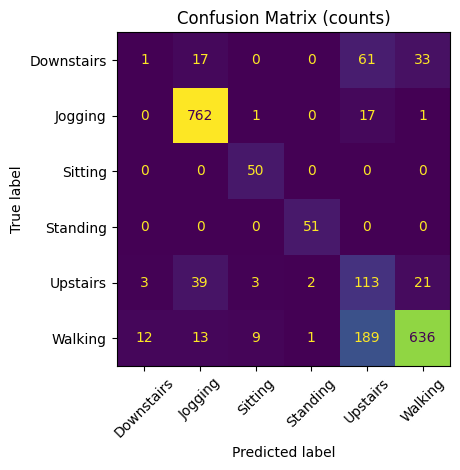

<Figure size 700x700 with 0 Axes>

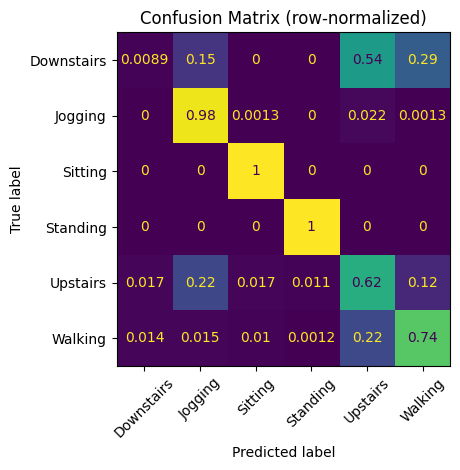

              precision    recall  f1-score   support

  Downstairs     0.0625    0.0089    0.0156       112
     Jogging     0.9170    0.9757    0.9454       781
     Sitting     0.7937    1.0000    0.8850        50
    Standing     0.9444    1.0000    0.9714        51
    Upstairs     0.2974    0.6243    0.4029       181
     Walking     0.9204    0.7395    0.8201       860

    accuracy                         0.7926      2035
   macro avg     0.6559    0.7247    0.6734      2035
weighted avg     0.8139    0.7926    0.7922      2035



In [31]:
# 혼동행렬 & 분류 리포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_te, y_pred, labels=range(N_CLASS), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2lab[i] for i in range(N_CLASS)])

plt.figure(figsize=(7,7))
disp.plot(include_values=True, xticks_rotation=45, cmap=None, colorbar=False)  # 색상 지정하지 않음
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()

# 정규화된 혼동행렬(행 기준 비율)도 함께  확인
cm_norm = confusion_matrix(y_te, y_pred, labels=range(N_CLASS), normalize="true")
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[id2lab[i] for i in range(N_CLASS)])

plt.figure(figsize=(7,7))
disp_norm.plot(include_values=True, xticks_rotation=45, cmap=None, colorbar=False)
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()

# 분류 리포트: precision/recall/f1 (macro/weighted)
print(classification_report(
    y_te, y_pred,
    target_names=[id2lab[i] for i in range(N_CLASS)],
    digits=4
))

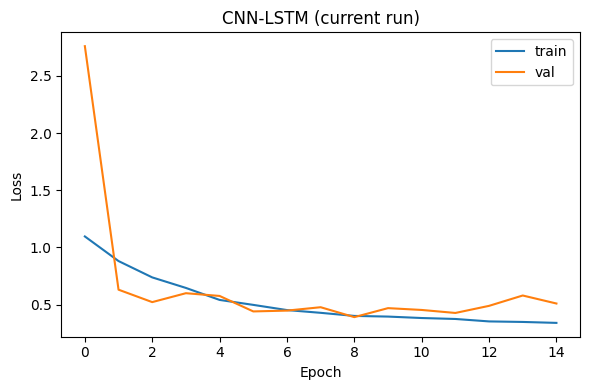

In [35]:
import matplotlib.pyplot as plt

# 학습곡선 그래프(Train/Val Loss)
def plot_history(hobj, title="Confusion Matrix (counts)"):
    h = hobj.history
    assert "loss" in h and "val_loss" in h, "loss/val_loss가 history에 없습니다."
    plt.figure(figsize=(6,4))
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

plot_history(history, title="CNN-LSTM (current run)")

## CNN-LSTM

In [44]:
# CNN-LSTM 모델 정의
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

SEQ_LEN = X_tr.shape[1]
N_CH    = X_tr.shape[2]
N_CLASS = len(id2lab)

def conv_block(x, filters, k=5, s=1, l2w=1e-4, p_drop=0.10):
    x = layers.Conv1D(filters, k, strides=s, padding="same",
                      kernel_regularizer=regularizers.l2(l2w), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout1D(p_drop)(x)
    return x

def build_cnn_lstm_regularized(seq_len=SEQ_LEN, n_ch=N_CH, n_class=N_CLASS):
    inp = layers.Input(shape=(seq_len, n_ch))          # (T, C)

    # Local temporal features (use strided conv instead of MaxPool)
    x = conv_block(inp,  64, k=5, s=1, p_drop=0.10)    # T
    x = conv_block(x,    96, k=5, s=2, p_drop=0.10)    # T/2
    x = conv_block(x,   128, k=5, s=2, p_drop=0.15)    # T/4

    # Sequence modeling (LSTM 그대로, 과적합 줄이려 recurrent_dropout 사용)
    x = layers.LSTM(96, recurrent_dropout=0.2)(x)
    x = layers.Dropout(0.40)(x)

    # Classifier head
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(n_class, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
    return model

model = build_cnn_lstm_regularized()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 200, 64)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 100, 96)        │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 100, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ (None, 100, 96)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 50, 128)        │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_11            │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,862 (757.27 KB)

 Trainable params: 193,286 (755.02 KB)

 Non-trainable params: 576 (2.25 KB)

In [45]:
# CNN-LSTM 학습
import gc, tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1) 안전 정리
try:
    del model
except:
    pass
gc.collect()

# 2) 입력/출력 차원 재설정 (파생채널 적용된 X_*7 기준)
SEQ_LEN = X_tr7.shape[1]
N_CH    = X_tr7.shape[2]
N_CLASS = len(id2lab)

# 3) 모델 재빌드
model = build_cnn_lstm_regularized(SEQ_LEN, N_CH, N_CLASS)
model.summary()

# 4) 클래스 가중치 (balanced)
classes = np.arange(N_CLASS)
cw_vals = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = {int(c): float(w) for c, w in zip(classes, cw_vals)}
print("class_weight:", class_weight)

# 5) 콜백 (변수명 충돌 피하려고 cb_list 사용)
cb_list = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6,
                                     restore_best_weights=True, min_delta=1e-3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                         patience=3, min_lr=1e-5, cooldown=1),
]

# 6) 학습 (입력은  X_tr7/X_va7 사용)
history = model.fit(
    X_tr7, y_tr,
    validation_data=(X_va7, y_va),
    epochs=50, batch_size=64,
    callbacks=cb_list,
    class_weight=class_weight,
    verbose=1
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 200, 64)        │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 100, 96)        │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 100, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 100, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_13            │ (None, 100, 96)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 128)        │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_14            │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,142 (762.27 KB)

 Trainable params: 194,566 (760.02 KB)

 Non-trainable params: 576 (2.25 KB)

class_weight: {0: 1.8688439606013478, 1: 0.5636335209505942, 2: 2.606652205350687, 3: 3.433333333333333, 4: 1.5646701388888888, 5: 0.4207516339869281}
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.4434 - loss: 1.3120 - val_accuracy: 0.4008 - val_loss: 2.9610 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6833 - loss: 0.8467 - val_accuracy: 0.7805 - val_loss: 0.6314 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7691 - loss: 0.7124 - val_accuracy: 0.8348 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.8212 - loss: 0.6395 - val_accuracy: 0.8248 - val_loss: 0.5993 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8445 - loss: 0.5910 - val_accuracy: 0.8640 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8693 - loss: 0.4

In [48]:
# === Evaluation helpers: report, confusion matrix, history plot ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def print_cls_report(model, X_test, y_test, id2lab):
    """
    모델로 예측 후 분류 리포트 출력.
    반환: y_pred (array)
    """
    y_prob = model.predict(X_test, verbose=0)
    if y_prob.ndim != 2:
        raise ValueError(f"Unexpected prediction shape: {y_prob.shape}")
    y_pred = y_prob.argmax(axis=1)

    labels = [id2lab[i] for i in range(len(id2lab))]
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))
    return y_pred

def plot_confusion(model, X_test, y_test, id2lab, normalize=None, figsize=(7,7)):
    """
    혼동행렬 그리기. normalize: None | 'true' | 'pred' | 'all'
    반환: (y_pred, cm)
    """
    y_prob = model.predict(X_test, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    labels = [id2lab[i] for i in range(len(id2lab))]
    cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=figsize)
    disp.plot(include_values=True, xticks_rotation=45, cmap=None, colorbar=False)
    title = "Confusion Matrix" + ("" if normalize is None else f" (normalize={normalize})")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return y_pred, cm

def plot_history(history_obj, title_prefix="CNN-LSTM (current run)"):
    """학습/검증 loss 및 (있다면) accuracy 곡선 그리기."""
    h = history_obj.history
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.legend()
    plt.title(f"{title_prefix} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()
    # Accuracy (옵션)
    if "accuracy" in h and "val_accuracy" in h:
        plt.figure(figsize=(6,4))
        plt.plot(h["accuracy"], label="train")
        plt.plot(h["val_accuracy"], label="val")
        plt.legend()
        plt.title(f"{title_prefix} — Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.tight_layout()
        plt.show()


In [49]:
# 분류 리포트
_ = print_cls_report(model, X_te7, y_te, id2lab)

=== Classification Report ===
              precision    recall  f1-score   support

  Downstairs     0.4167    0.5357    0.4688       112
     Jogging     0.9750    0.8976    0.9347       781
     Sitting     0.4167    1.0000    0.5882        50
    Standing     0.0000    0.0000    0.0000        51
    Upstairs     0.6931    0.7735    0.7311       181
     Walking     0.9376    0.9267    0.9322       860

    accuracy                         0.8590      2035
   macro avg     0.5732    0.6889    0.6091      2035
weighted avg     0.8652    0.8590    0.8579      2035



<Figure size 700x700 with 0 Axes>

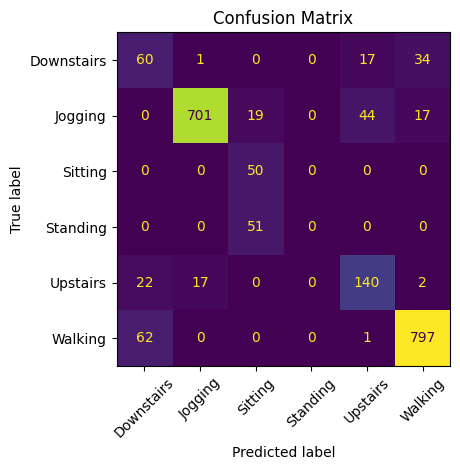

<Figure size 700x700 with 0 Axes>

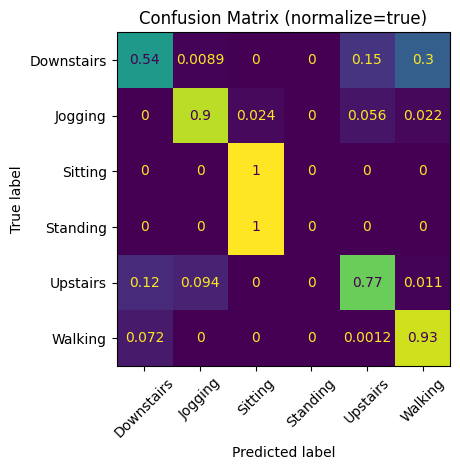

In [50]:
# 혼동행렬 (카운트 & 행 정규화)
_ = plot_confusion(model, X_te7, y_te, id2lab, normalize=None)
_ = plot_confusion(model, X_te7, y_te, id2lab, normalize="true")

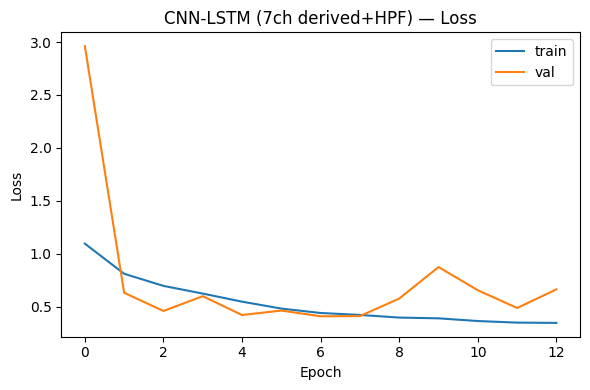

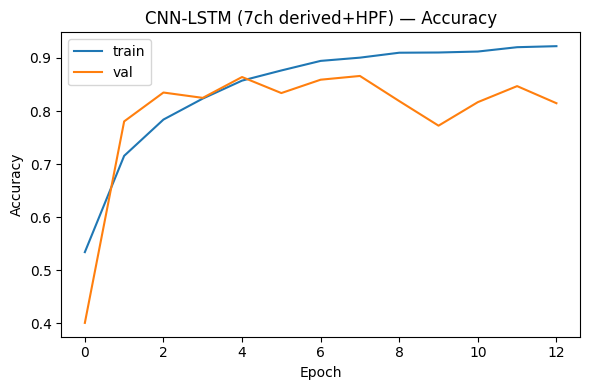

In [51]:
# 학습곡선
plot_history(history, title_prefix="CNN-LSTM (7ch derived+HPF)")